In [36]:
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import esmlab
from glob import glob
import cartopy
import cartopy.crs as ccrs
import seawater as sw
from seawater.library import T90conv
import esmlab
import warnings
warnings.filterwarnings('ignore')
import util

#### Looking for signatures of calcification in observations

#### Define some function

In [8]:
def interp3d(coord_field,ds,new_levels,dim,**kwargs):
    '''kludged function for interpolation
    '''

    method = kwargs.pop('method','linear')
    if method == 'linear':
        from metpy.interpolate import interpolate_1d
        interp_func = interpolate_1d
    elif method == 'log':
        from metpy.interpolate import log_interpolate_1d
        interp_func = log_interpolate_1d

    newdim = new_levels.dims[0]

    dso = xr.Dataset()
    for v in ds.variables:

        if dim not in ds[v].dims:
            dso[v] = ds[v]
        else:

            dims_in = ds[v].dims
            if len(dims_in) == 1: continue

            interp_axis = dims_in.index(dim)
            dims_out = list(dims_in)
            dims_out[interp_axis] = newdim

            dso[v] = xr.DataArray(
                interp_func(new_levels.values,
                            coord_field.values,ds[v].values,axis=interp_axis),
                dims=dims_out,attrs=ds[v].attrs)
    dso[newdim] = new_levels
    return dso

In [3]:
ds = xr.open_mfdataset('/glade/work/kristenk/GLODAPv2_regridded/*.nc',decode_times=False,decode_coords=False)
ds = ds.rename({'depth_surface':'depth'})

In [4]:
Alk3=(ds.TAlk + 1.36 * ds.NO3)/ ds.salinity * 35
ds['sPAlk'] = xr.DataArray(Alk3,dims=('depth','lat','lon'))

In [5]:
na = np.newaxis
pressure = sw.eos80.pres(ds.depth.values[:,na,na],ds.lat.values[na,:,na])
pDensity = sw.pden(ds.salinity, ds.temperature, pressure)-1000.

In [6]:
ds['pdens'] = xr.DataArray(pDensity,dims=('depth','lat','lon'))

In [7]:
area = xr.DataArray(np.zeros([180,360]), dims=('lat','lon'))
j=0
for lat in ds.lat.values:
    
    pi     =    3.14159265359
    radius = 6378.137

    deg2rad = pi / 180.0

    resolution_lat =1.
    resolution_lon =1.

    elevation = deg2rad * (lat + (resolution_lat / 2.0))

    deltalat = deg2rad * resolution_lon
    deltalon = deg2rad * resolution_lat

    area[j,:] = (2.0*radius**2*deltalon*np.cos(elevation)*np.sin((deltalat/2.0)))
    
    j = j + 1
    
ds['area']=area

In [9]:
sigma_coord = xr.DataArray(np.arange(21., 29., 0.2),dims='sigma')
ds_sigma = interp3d(ds.pdens,ds,sigma_coord,'depth',method='linear')

In [12]:
ds_sigma.TAlk.units

'micromol kg-1'

In [18]:
ds_sigma.sigma[30]

<xarray.DataArray 'sigma' ()>
array(27.)
Coordinates:
    sigma    float64 27.0

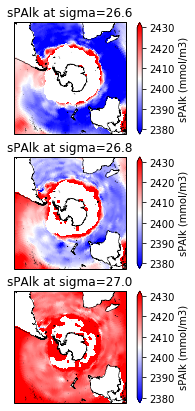

In [20]:
fig = plt.figure(figsize=(4,7))
#fig.suptitle('Does calcification in the GCB cause observed Alk* anomalies in SAMW (mean sigma 26 to 27)?')
#----------
ax = fig.add_subplot(3,1,1, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('sPAlk at sigma=26.6')
pc=ax.pcolormesh(ds_sigma.lon, ds_sigma.lat, 
                 ds_sigma.sPAlk.isel(sigma=28)*1.026, vmin=2380, vmax=2430, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')


#----------
ax = fig.add_subplot(3,1,2, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('sPAlk at sigma=26.8')
pc=ax.pcolormesh(ds_sigma.lon, ds_sigma.lat, 
                 ds_sigma.sPAlk.isel(sigma=29)*1.026, vmin=2380, vmax=2430, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')

#----------
ax = fig.add_subplot(3,1,3, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('sPAlk at sigma=27.0')
pc=ax.pcolormesh(ds_sigma.lon, ds_sigma.lat, 
                 ds_sigma.sPAlk.isel(sigma=30)*1.026, vmin=2380, vmax=2430, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')

#### In CESM

In [24]:
start_yr=280
num_years=5
endyr=start_yr + num_years 
case = 'cesm22cocco.G1850ECOIAF.T62_g17.003'
user = 'kristenk'

In [25]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    #print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/scratch/{user}/archive/{case}/ocn/hist/{case}.pop.h.{yr4}-{mo2}.nc')))

In [26]:
cesm_mon_ds=xr.open_mfdataset(files,decode_times=False,decode_coords=False, concat_dim='time')

In [27]:
coords = {'x':'TLONG','y':'TLAT'}
keepthese=['z_t','z_t_150m','time_bound','TAREA','NO3','coccoCaCO3','SALT','ALK','ALK_ALT_CO2','TEMP']
keep_vars = keepthese +list(coords.values())+['dz','KMT']
cesm_mon_ds = cesm_mon_ds.drop([v for v in cesm_mon_ds.variables if v not in keep_vars])

In [72]:
%%time
ds_annmean=cesm_mon_ds.mean(dim='time').compute()

CPU times: user 36.2 s, sys: 27.9 s, total: 1min 4s
Wall time: 52.6 s


In [73]:
Alk3=(ds_annmean.ALK + 1.36 * ds_annmean.NO3)/ ds_annmean.SALT * 35.
ds_annmean['sPAlk']=xr.DataArray(Alk3,dims=('z_t','nlat','nlon'))

Alk3_alt=(ds_annmean.ALK_ALT_CO2 + 1.36 * ds_annmean.NO3)/ ds_annmean.SALT * 35.
ds_annmean['sPAlk_alt']=xr.DataArray(Alk3_alt,dims=('z_t','nlat','nlon'))

In [74]:
na = np.newaxis
pressure = sw.eos80.pres(ds_annmean.z_t.values[:,na,na]/100.,ds_annmean.TLAT.values[na,:,:])

In [75]:
#now calculate potential density
pDensity = sw.pden(ds_annmean.SALT, ds_annmean.TEMP, pressure)-1000.
ds_annmean['pdens'] = xr.DataArray(pDensity,dims=('z_t','nlat','nlon'))

In [76]:
sigma_coord = xr.DataArray(np.arange(21., 29., 0.2),dims='sigma')
ds_sigma_cesm = interp3d(ds_annmean.pdens, ds_annmean, sigma_coord, 'z_t', method='linear')

In [77]:
file = '/glade/work/kristenk/WOA_data/regrid_POP/WOA2013_POPgrid.nc' 
ds_woa = xr.load_dataset(file, decode_times=False, decode_coords=False)
ds_woa['z_t'] = ds_annmean.z_t

ds_annmean['TLAT'] = ds_woa.TLAT
ds_annmean['TLONG'] = ds_woa.TLONG
ds_annmean['TAREA'] = ds_woa.TAREA


ds_sigma_cesm['TLAT'] = ds_woa.TLAT
ds_sigma_cesm['TLONG'] = ds_woa.TLONG
ds_sigma_cesm['TAREA'] = ds_woa.TAREA

depths = ds_annmean.z_t * 0.01

In [80]:
ds_annmean = util.pop_add_cyclic(ds_annmean)
ds_sigma_cesm = util.pop_add_cyclic(ds_sigma_cesm)

In [85]:
sh = ds_annmean.TLAT[:, 0] < 0 #just southern hemisphere

In [86]:
lat = ds_annmean.TLAT[sh,:]
lon = ds_annmean.TLONG[sh,:]

In [195]:
sPalk_sig266 = ds_sigma_cesm.sPAlk.isel(sigma=28)[sh,:]
sPalk_sig268 = ds_sigma_cesm.sPAlk.isel(sigma=29)[sh,:]
sPalk_sig270 = ds_sigma_cesm.sPAlk.isel(sigma=30)[sh,:]

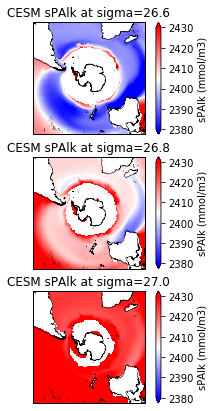

In [196]:
fig = plt.figure(figsize=(4,7))
#fig.suptitle('Does calcification in the GCB cause observed Alk* anomalies in SAMW (mean sigma 26 to 27)?')
#----------
ax = fig.add_subplot(3,1,1, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM sPAlk at sigma=26.6')
pc=ax.pcolormesh(lon, lat, 
                 sPalk_sig266, vmin=2380, vmax=2430, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')


#----------
ax = fig.add_subplot(3,1,2, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM sPAlk at sigma=26.8')
pc=ax.pcolormesh(lon, lat, 
                 sPalk_sig268, vmin=2380, vmax=2430, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')

#----------
ax = fig.add_subplot(3,1,3, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM sPAlk at sigma=27.0')
pc=ax.pcolormesh(lon, lat, 
                 sPalk_sig270, vmin=2380, vmax=2430, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')

In [198]:
sPalk_sig266_alt = ds_sigma_cesm.sPAlk_alt.isel(sigma=28)[sh,:]
sPalk_sig268_alt = ds_sigma_cesm.sPAlk_alt.isel(sigma=29)[sh,:]
sPalk_sig270_alt = ds_sigma_cesm.sPAlk_alt.isel(sigma=30)[sh,:]

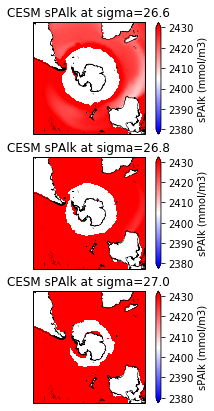

In [199]:
fig = plt.figure(figsize=(4,7))
#fig.suptitle('Does calcification in the GCB cause observed Alk* anomalies in SAMW (mean sigma 26 to 27)?')
#----------
ax = fig.add_subplot(3,1,1, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM sPAlk at sigma=26.6')
pc=ax.pcolormesh(lon, lat, 
                 sPalk_sig266_alt, vmin=2380, vmax=2430, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')


#----------
ax = fig.add_subplot(3,1,2, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM sPAlk at sigma=26.8')
pc=ax.pcolormesh(lon, lat, 
                 sPalk_sig268_alt, vmin=2380, vmax=2430, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')

#----------
ax = fig.add_subplot(3,1,3, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM sPAlk at sigma=27.0')
pc=ax.pcolormesh(lon, lat, 
                 sPalk_sig270_alt, vmin=2380, vmax=2430, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')

### Put these all together

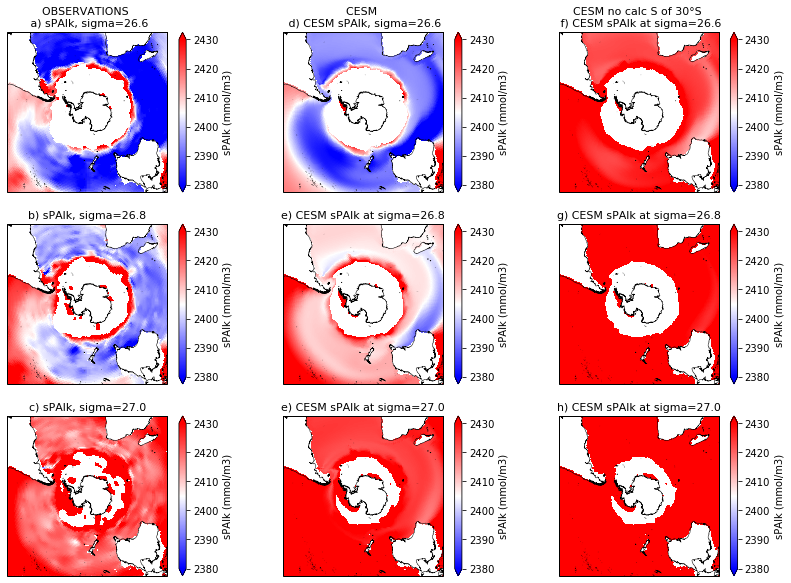

In [278]:
fig = plt.figure(figsize=(14,10))
#fig.suptitle('Does calcification in the GCB cause observed Alk* anomalies in SAMW (mean sigma 26 to 27)?')
#----------
ax = fig.add_subplot(3,3,1, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('OBSERVATIONS \n a) sPAlk, sigma=26.6',fontsize=11)
pc=ax.pcolormesh(ds_sigma.lon, ds_sigma.lat, 
                 ds_sigma.sPAlk.isel(sigma=28)*1.026, vmin=2380, vmax=2430, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')


#----------
ax = fig.add_subplot(3,3,4, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('b) sPAlk, sigma=26.8',fontsize=11)
pc=ax.pcolormesh(ds_sigma.lon, ds_sigma.lat, 
                 ds_sigma.sPAlk.isel(sigma=29)*1.026, vmin=2380, vmax=2430, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')

#----------
ax = fig.add_subplot(3,3,7, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('c) sPAlk, sigma=27.0',fontsize=11)
pc=ax.pcolormesh(ds_sigma.lon, ds_sigma.lat, 
                 ds_sigma.sPAlk.isel(sigma=30)*1.026, vmin=2380, vmax=2430, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')

#--------------------------------------------------------------------------
ax = fig.add_subplot(3,3,2, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM \n d) CESM sPAlk, sigma=26.6',fontsize=11)
pc=ax.pcolormesh(lon, lat, 
                 sPalk_sig266, vmin=2380, vmax=2430, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')


#----------
ax = fig.add_subplot(3,3,5, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('e) CESM sPAlk at sigma=26.8',fontsize=11)
pc=ax.pcolormesh(lon, lat, 
                 sPalk_sig268, vmin=2380, vmax=2430, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')

#----------
ax = fig.add_subplot(3,3,8, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('e) CESM sPAlk at sigma=27.0',fontsize=11)
pc=ax.pcolormesh(lon, lat, 
                 sPalk_sig270, vmin=2380, vmax=2430, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')


#------------------------------------------------------------------------------------------------
ax = fig.add_subplot(3,3,3, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM no calc S of 30°S \n f) CESM sPAlk at sigma=26.6',fontsize=11)
pc=ax.pcolormesh(lon, lat, 
                 sPalk_sig266_alt, vmin=2380, vmax=2430, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')


#----------
ax = fig.add_subplot(3,3,6, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('g) CESM sPAlk at sigma=26.8',fontsize=11)
pc=ax.pcolormesh(lon, lat, 
                 sPalk_sig268_alt, vmin=2380, vmax=2430, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')

#----------
ax = fig.add_subplot(3,3,9, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('h) CESM sPAlk at sigma=27.0',fontsize=11)
pc=ax.pcolormesh(lon, lat, 
                 sPalk_sig270_alt, vmin=2380, vmax=2430, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')



### Finding a reference sPAlk

In [260]:
sPAlk_ref= esmlab.weighted_mean(ds_sigma_cesm['sPAlk'].isel(sigma=slice(28,31)), weights=ds_annmean.TAREA, dim=['nlat', 'nlon']).compute()
sPAlk_ref.mean(dim='sigma')

<xarray.DataArray ()>
array(2420.04367346)
Attributes:
    long_name:     Alkalinity
    units:         meq/m^3
    coordinates:   TLONG TLAT z_t time
    grid_loc:      3111
    cell_methods:  time: mean

In [261]:
sPAlk_ref_obs= esmlab.weighted_mean(ds_sigma['sPAlk'].isel(sigma=slice(28,31)), weights=ds.area, dim=['lat', 'lon']).compute()
(sPAlk_ref_obs * 1.026).mean(dim='sigma')


<xarray.DataArray ()>
array(2420.16852047)
Attributes:
    long_name:  total alkalinity
    units:      micromol kg-1

In [263]:
sPAlk_ref_alt= esmlab.weighted_mean(ds_sigma_cesm['sPAlk_alt'].isel(sigma=slice(28,31)), weights=ds_annmean.TAREA, dim=['nlat', 'nlon']).compute()
sPAlk_ref_alt.mean(dim='sigma')

<xarray.DataArray ()>
array(2441.82021479)
Attributes:
    long_name:     Alkalinity, Alternative CO2
    units:         meq/m^3
    coordinates:   TLONG TLAT z_t time
    grid_loc:      3111
    cell_methods:  time: mean

In [270]:
sPAlk_ref_alt= esmlab.weighted_mean(ds_annmean['sPAlk_alt'], weights=ds_annmean.TAREA, dim=['nlat', 'nlon']).compute()
sPAlk_ref_alt  #.mean(dim='z_t')

<xarray.DataArray (z_t: 60)>
array([2408.83602472, 2408.71646048, 2408.45033173, 2405.33097686,
       2404.74541022, 2404.39504358, 2403.87481006, 2403.61723723,
       2403.77166525, 2403.833673  , 2404.35649412, 2405.02129576,
       2405.96455452, 2407.00617289, 2408.14335607, 2409.34425155,
       2410.62092147, 2411.97053792, 2413.4176776 , 2414.98943818,
       2416.60230364, 2418.38710037, 2420.21115354, 2422.20215977,
       2424.32218335, 2426.52780033, 2428.70661402, 2431.07207136,
       2433.63143692, 2436.37283694, 2439.32054428, 2442.45778516,
       2445.94906836, 2449.71986066, 2453.88793758, 2458.37537585,
       2463.13257084, 2468.25241777, 2473.47764777, 2478.16394448,
       2482.83177254, 2487.1957172 , 2490.55594934, 2493.96902007,
       2496.3658736 , 2497.72129722, 2498.01782438, 2500.06356826,
       2502.00618274, 2503.77207549, 2505.18572407, 2505.90633834,
       2506.47607521, 2506.46066269, 2505.90711698, 2505.51876217,
       2505.5280804 , 2507.387795

In [272]:
sPAlk_ref= esmlab.weighted_mean(ds_annmean['sPAlk'].where(ds_annmean.TLAT<-60.), weights=ds_annmean.TAREA, dim=['nlat', 'nlon']).compute()
sPAlk_ref  #.mean(dim='z_t')

<xarray.DataArray (z_t: 60)>
array([2450.82463295, 2450.72023529, 2450.62763957, 2450.48571975,
       2450.28738187, 2450.20654297, 2450.2060969 , 2450.27096767,
       2450.42073421, 2450.69209141, 2451.11474635, 2451.69374365,
       2452.37268489, 2453.08842922, 2453.80182616, 2454.48094582,
       2455.12105055, 2455.7340267 , 2456.3190152 , 2456.87777407,
       2457.41769935, 2457.93639226, 2458.44210873, 2458.94456977,
       2459.44255422, 2459.93528129, 2460.42331493, 2460.90210789,
       2461.36124598, 2461.80171272, 2462.22956075, 2462.65946051,
       2463.12962449, 2463.5842141 , 2464.0644631 , 2464.61981747,
       2465.15973345, 2465.75005718, 2466.42934409, 2467.1811118 ,
       2468.02725784, 2468.96757148, 2469.99124093, 2471.05196895,
       2472.11592881, 2473.09371869, 2473.98566897, 2474.74800089,
       2475.37505397, 2475.92847143, 2476.34681093, 2476.66584376,
       2477.03360638, 2477.50759844, 2478.31282744, 2479.81435841,
       2480.83748324, 2481.512983

In [273]:
sPAlk_ref_obs = esmlab.weighted_mean(ds['sPAlk'].where(ds.lat<-60.), weights=ds.area, dim=['lat', 'lon']).compute()
sPAlk_ref_obs = sPAlk_ref_obs * 1.026
sPAlk_ref_obs

<xarray.DataArray (depth: 33)>
array([2470.34038927, 2470.33848904, 2470.03198211, 2468.6941755 ,
       2467.10584399, 2469.27790681, 2469.65217303, 2471.14563263,
       2472.33328308, 2473.83803827, 2473.94843208, 2474.45280456,
       2475.02758814, 2476.0143335 , 2477.2209946 , 2478.10202268,
       2479.21382714, 2479.96092448, 2480.7280789 , 2481.4743975 ,
       2482.23656162, 2482.66551696, 2483.20675187, 2483.84809418,
       2484.97905828, 2485.62722722, 2486.39589024, 2486.63941974,
       2486.60951493, 2486.50820166, 2487.04731947, 2486.59017078,
                 nan])
Coordinates:
  * depth    (depth) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
Attributes:
    long_name:  total alkalinity
    units:      micromol kg-1

In [131]:
ds.depth

<xarray.DataArray 'depth' (depth: 33)>
array([   0.,   10.,   20.,   30.,   50.,   75.,  100.,  125.,  150.,  200.,
        250.,  300.,  400.,  500.,  600.,  700.,  800.,  900., 1000., 1100.,
       1200., 1300., 1400., 1500., 1750., 2000., 2500., 3000., 3500., 4000.,
       4500., 5000., 5500.])
Coordinates:
  * depth    (depth) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03

In [228]:
sPAlk_ref_obs = 2400
sPAlk_ref = 2410

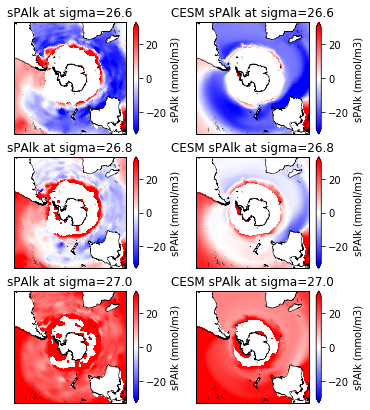

In [229]:
fig = plt.figure(figsize=(6,7))
#fig.suptitle('Does calcification in the GCB cause observed Alk* anomalies in SAMW (mean sigma 26 to 27)?')
#----------
ax = fig.add_subplot(3,2,1, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('sPAlk at sigma=26.6')
pc=ax.pcolormesh(ds_sigma.lon, ds_sigma.lat, 
                 ds_sigma.sPAlk.isel(sigma=28)*1.026-sPAlk_ref_obs, 
                 vmin=-30, vmax=30, 
                 cmap='bwr', transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')


#----------
ax = fig.add_subplot(3,2,3, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('sPAlk at sigma=26.8')
pc=ax.pcolormesh(ds_sigma.lon, ds_sigma.lat, 
                 ds_sigma.sPAlk.isel(sigma=29)*1.026-sPAlk_ref_obs, 
                 vmin=-30, vmax=30, 
                 cmap='bwr', transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')

#----------
ax = fig.add_subplot(3,2,5, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('sPAlk at sigma=27.0')
pc=ax.pcolormesh(ds_sigma.lon, ds_sigma.lat, 
                 ds_sigma.sPAlk.isel(sigma=30)*1.026-sPAlk_ref_obs, 
                 vmin=-30, vmax=30, 
                 cmap='bwr', transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')



#----------#----------#----------#----------#----------#----------#----------


ax = fig.add_subplot(3,2,2, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM sPAlk at sigma=26.6')
pc=ax.pcolormesh(lon, lat, 
                 sPalk_sig266 - sPAlk_ref, 
                 vmin=-30, vmax=30, 
                 cmap='bwr',transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')


#----------
ax = fig.add_subplot(3,2,4, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM sPAlk at sigma=26.8')
pc=ax.pcolormesh(lon, lat, 
                 sPalk_sig268- sPAlk_ref, 
                 vmin=-30, vmax=30, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')

#----------
ax = fig.add_subplot(3,2,6, projection=ccrs.SouthPolarStereo())

ax.set_extent([-180, 180, -90, -20], ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
ax.set_title('CESM sPAlk at sigma=27.0')
pc=ax.pcolormesh(lon, lat, 
                 sPalk_sig270- sPAlk_ref, 
                 vmin=-30, vmax=30, cmap='bwr',
                 transform=ccrs.PlateCarree())
cbar1 = fig.colorbar(pc, ax=ax,extend='both',label='sPAlk (mmol/m3)')